# Fourth
batch size 2048 lr 1e-3 swish mult2

### Import modules

In [1]:
%matplotlib inline
from __future__ import division
import sys
import os
os.environ['MKL_THREADING_LAYER']='GNU'
sys.path.append('../')
from Modules.Basics import *
from Modules.Class_Basics import *

/home/giles/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
Using Theano backend.
/home/giles/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Options

In [2]:
classTrainFeatures = basic_features
classModel = 'modelSwish'
varSet = "basic_features"

nSplits = 10
ensembleSize = 10
ensembleMode = 'loss'

maxEpochs = 200
compileArgs = {'loss':'binary_crossentropy', 'optimizer':'adam'}
trainParams = {'epochs' : 1, 'batch_size' : 2048, 'verbose' : 0}
modelParams = {'version':classModel, 'nIn':len(classTrainFeatures), 'compileArgs':compileArgs}

print "\nTraining on", len(classTrainFeatures), "features:", [var for var in classTrainFeatures]


Training on 5 features: ['jetPt', 'jetEta', 'jetMass', 'ntracks', 'ntowers']


## Import data

In [3]:
trainData = h5py.File(dirLoc + 'train.hdf5', "r+")
valData = h5py.File(dirLoc + 'testing.hdf5', "r+")

## Determine LR

2 classes found, running in binary mode


______________________________________
Training finished
Cross-validation took 3.856s 


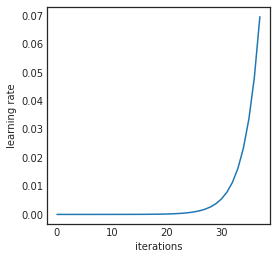

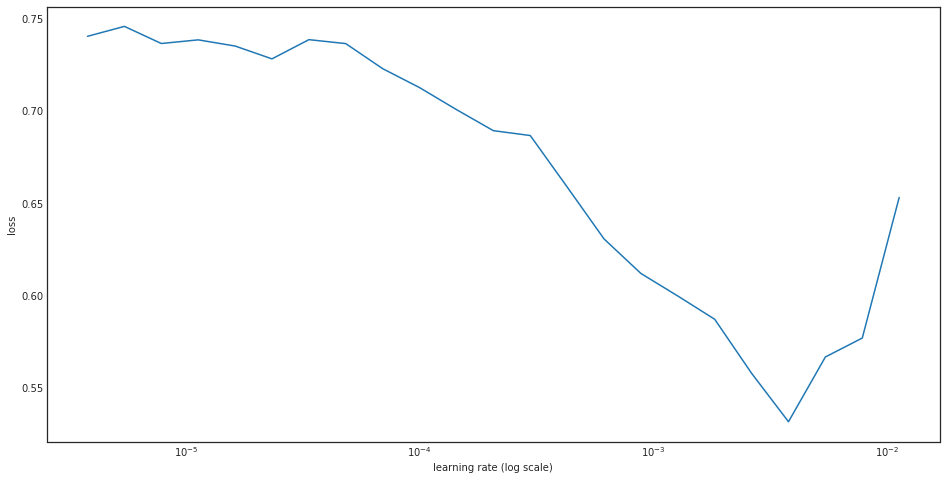

______________________________________



In [5]:
lrFinder = batchLRFindClassifier(trainData, nSplits, getClassifier, modelParams, trainParams, lrBounds=[1e-7,1e-1], trainOnWeights=False, verbose=0)

In [6]:
compileArgs['lr'] = 1e-3

## Train classifier

Using cosine annealing
Running fold 1 / 10
2 classes found, running in binary mode

1 New best found: 0.500064283385
2 New best found: 0.489763653375
3 New best found: 0.488910729916
4 New best found: 0.488837320495
5 New best found: 0.488535770955
6 New best found: 0.488178849397
7 New best found: 0.488039123098
11 New best found: 0.487873204761
13 New best found: 0.48759445645
15 New best found: 0.487539902291
25 New best found: 0.487507500574
26 New best found: 0.487312235538
30 New best found: 0.487276713499
31 New best found: 0.487273462724
Early stopping after 51 epochs
Score is: {'loss': 0.48727346272425642, 'AUC': 0.21077276546220469}
Fold took 142.857s

Running fold 2 / 10
1 New best found: 0.500975939736
2 New best found: 0.493431048247
3 New best found: 0.491863878027
4 New best found: 0.491268988423
5 New best found: 0.490795400436
6 New best found: 0.490311074081
7 New best found: 0.490242211328
11 New best found: 0.490009437218
12 New best found: 0.489984623071
13 New bes

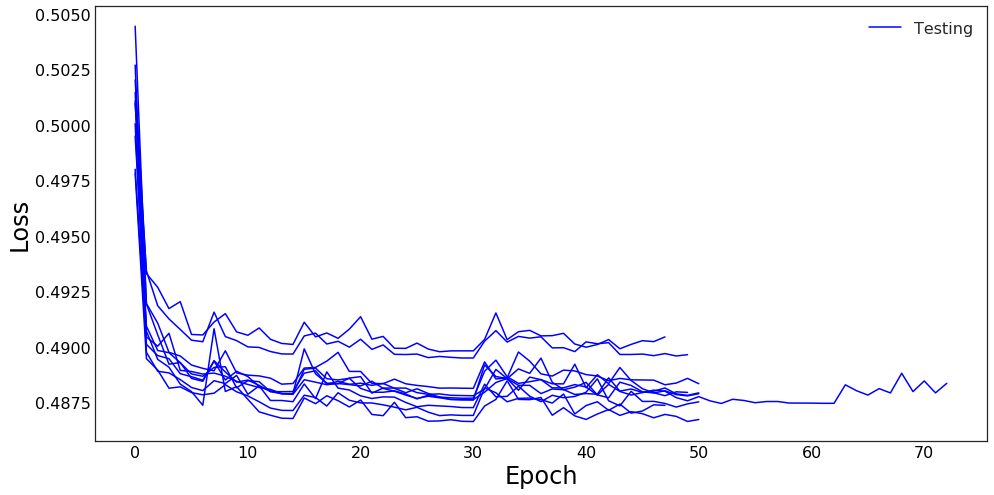

Mean AUC = 0.2116 +- 0.0004
______________________________________



In [7]:
results, histories = batchTrainClassifier(trainData, nSplits, getClassifier, modelParams, trainParams, patience=20, cosAnnealMult=2, trainOnWeights=False, maxEpochs=maxEpochs, verbose=1)

## Construct ensemble

In [8]:
with open('train_weights/resultsFile.pkl', 'r') as fin:   
    results = pickle.load(fin)

In [9]:
ensemble, weights = assembleEnsemble(results, ensembleSize, ensembleMode, compileArgs)

Choosing ensemble by loss
Model 0 is 3 with loss = 0.486646318545
Model 1 is 8 with loss = 0.486913169616
Model 2 is 0 with loss = 0.487273462724
Model 3 is 2 with loss = 0.487460894471
Model 4 is 7 with loss = 0.487635441997
Model 5 is 6 with loss = 0.487695758092
Model 6 is 5 with loss = 0.487807964388
Model 7 is 4 with loss = 0.488140672312
Model 8 is 1 with loss = 0.489508615131
Model 9 is 9 with loss = 0.489790946755


## Response on development data

In [18]:
batchEnsemblePredict(ensemble, weights, trainData, ensembleSize=10, nFolds=nSplits, verbose=1)

Predicting batch 1 out of 10
Prediction took 0.00015809716559s per sample

Predicting batch 2 out of 10
Prediction took 0.000157014257411s per sample

Predicting batch 3 out of 10
Prediction took 0.000156285983997s per sample

Predicting batch 4 out of 10
Prediction took 0.0001560477174s per sample

Predicting batch 5 out of 10
Prediction took 0.000162383253495s per sample

Predicting batch 6 out of 10
Prediction took 0.000160539430008s per sample

Predicting batch 7 out of 10
Prediction took 0.000165407203664s per sample

Predicting batch 8 out of 10
Prediction took 0.000160640786129s per sample

Predicting batch 9 out of 10
Prediction took 0.000163513061909s per sample

Predicting batch 10 out of 10
Prediction took 0.000157657957799s per sample



In [20]:
print 'Training ROC AUC {}'.format(roc_auc_score(getFeature('targets', trainData, nSplits), getFeature('pred', trainData, nSplits)))

Training ROC AUC 0.790061869093


## Response on val data

In [22]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=10, nFolds=nSplits, verbose=1)

Predicting batch 1 out of 10
Prediction took 0.000154532365968s per sample

Predicting batch 2 out of 10
Prediction took 0.000157233041377s per sample

Predicting batch 3 out of 10
Prediction took 0.000150792287155s per sample

Predicting batch 4 out of 10
Prediction took 0.000158000382498s per sample

Predicting batch 5 out of 10
Prediction took 0.000156778577587s per sample

Predicting batch 6 out of 10
Prediction took 0.000156099680474s per sample

Predicting batch 7 out of 10
Prediction took 0.000159933625528s per sample

Predicting batch 8 out of 10
Prediction took 0.000162003922548s per sample

Predicting batch 9 out of 10
Prediction took 0.000156899805955s per sample

Predicting batch 10 out of 10
Prediction took 0.000167506006756s per sample



In [23]:
print 'Testing ROC AUC: {}'.format(roc_auc_score(getFeature('targets', valData, nSplits), getFeature('pred', valData, nSplits)))

Testing ROC AUC: 0.787243453619


## Evaluation

### Import in dataframe

In [24]:
def convertToDF(datafile, columns={'gen_target', 'gen_weight', 'pred_class'}, nLoad=-1):
    data = pandas.DataFrame()
    data['gen_target'] = getFeature('targets', datafile, nLoad)
    data['pred_class'] = getFeature('pred', datafile, nLoad)
    print len(data), "candidates loaded"
    return data

In [26]:
valData = convertToDF(valData, nLoad=nSplits)

313510 candidates loaded


In [27]:
sigVal = (valData.gen_target == 1)
bkgVal = (valData.gen_target == 0)

### MVA distributions

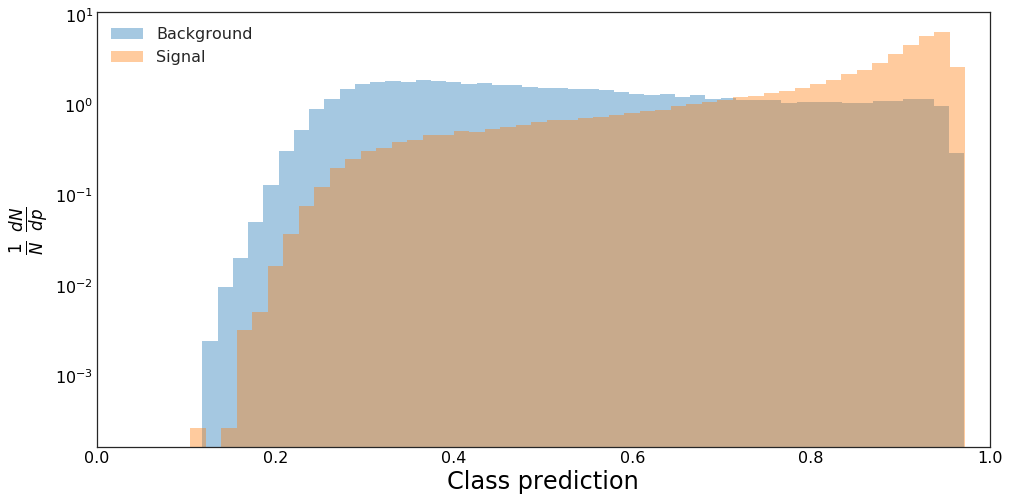

In [28]:
getClassPredPlot([valData[bkgVal], valData[sigVal]])